In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error
from sklearn.linear_model import *
from rdkit.Chem import AllChem, Draw, Descriptors, PandasTools
pd.set_option('display.max_rows', 500)

import doptools
import pickle
from chython import smiles

def r2(a, b):
    return 1. - np.sum((a-b)**2)/np.sum((a-np.mean(a))**2)

def rmse(a, b):
    return np.sqrt(np.sum((a-b)**2)/len(a))

from sklearn.metrics import mean_absolute_error as mae

colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00']

# Retention factor (ln$k$) cross-validation

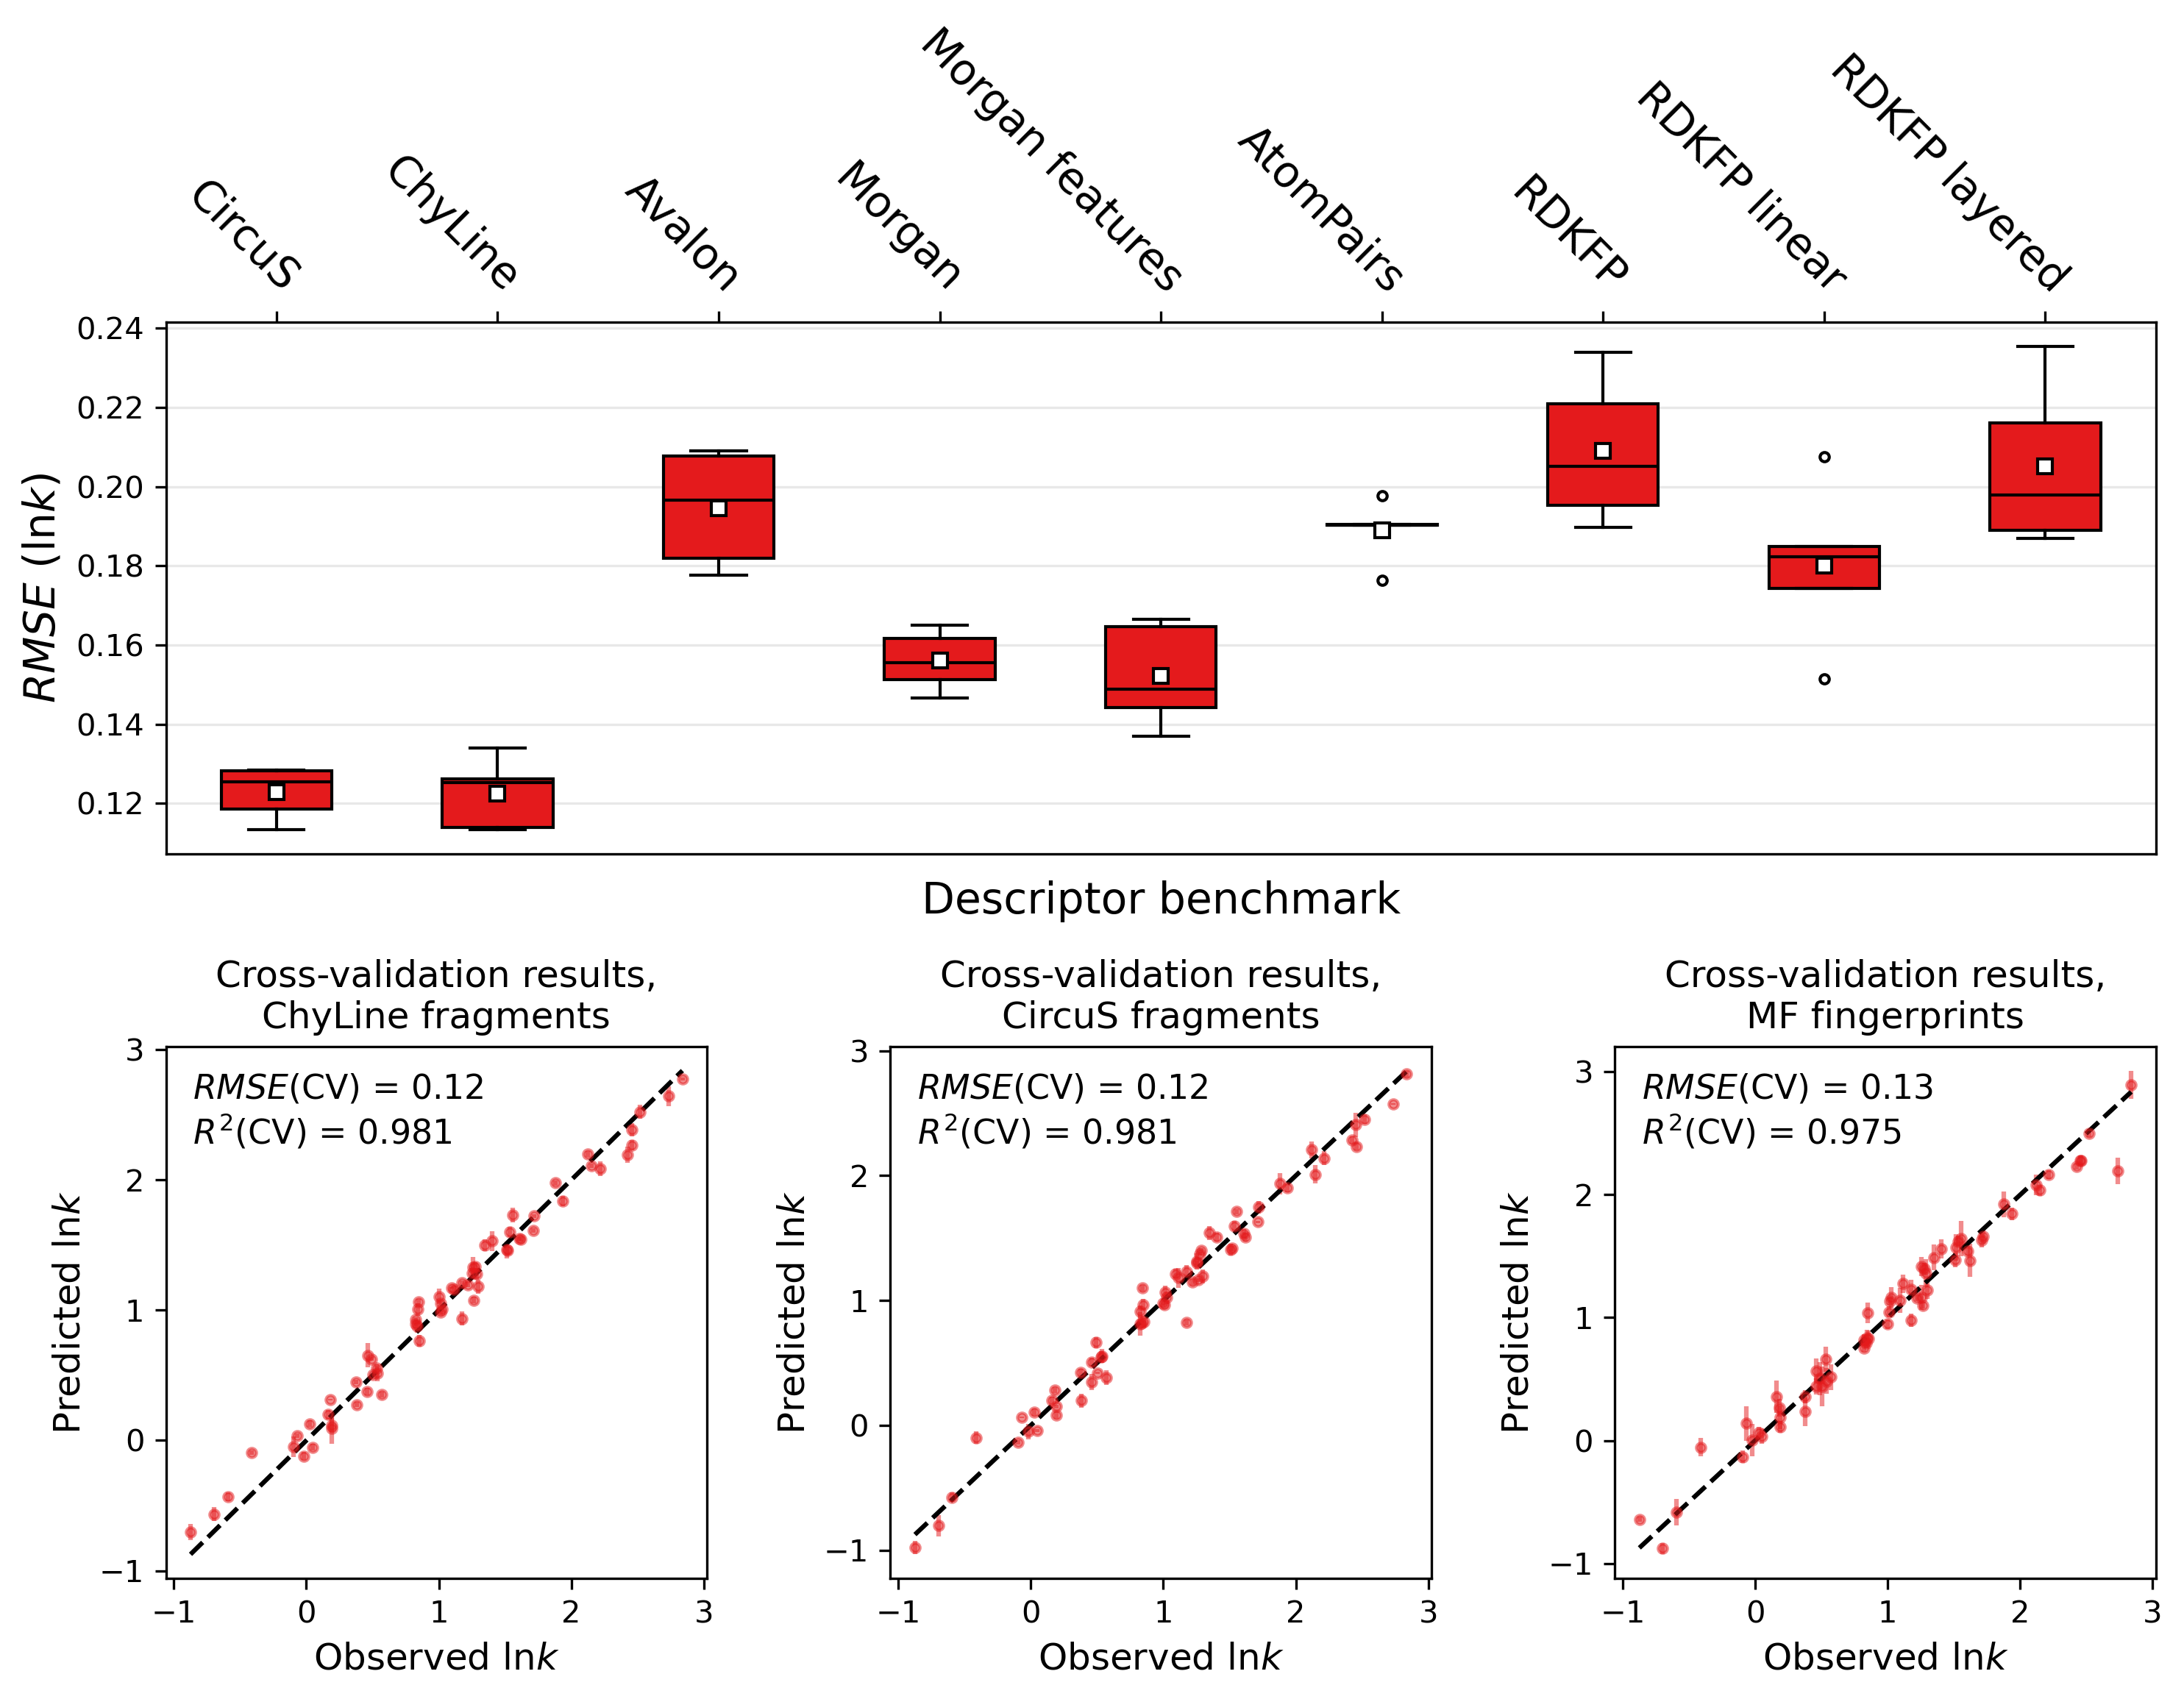

In [2]:
names = {'RDKFP':'CV_results/LnRF_rdkfp_SVR',
         'RDKFP layered':'CV_results/LnRF_layered_SVR',
         'ChyLine':'CV_results/LnRF_chyline_SVR',
         'Morgan':'CV_results/LnRF_morgan_SVR',
         'CircuS':'CV_results/LnRF_circus_SVR',
         'RDKFP linear':'CV_results/LnRF_rdkfplinear_SVR',
         'AtomPairs':'CV_results/LnRF_atompairs_SVR',
         'Morgan features':'CV_results/LnRF_morganfeatures_SVR',
         'Avalon':'CV_results/LnRF_avalon_SVR'}

fig = plt.figure(figsize = (10,7.8), dpi=300, facecolor="w")


ax1 = plt.subplot2grid((2, 3), (0, 0), colspan=3)
ax2 = plt.subplot2grid((2, 3), (1, 0))
ax3 = plt.subplot2grid((2, 3), (1, 1))
ax4 = plt.subplot2grid((2, 3), (1, 2))

cv_rmse_results = []
for i, dtype in enumerate(["CircuS", "ChyLine", "Avalon", "Morgan", 'Morgan features', 'AtomPairs', 
                           "RDKFP", "RDKFP linear", 'RDKFP layered']):
    d = dtype.lower()
    cv_rmse_results.append([])

    best = pd.read_table(names[dtype]+'/trials.best', sep=' ').iloc[0].trial
    cv_res = pd.read_table(names[dtype]+"/trial."+str(best)+"/predictions", sep=' ')
    a = cv_res["Exp_LnRF.observed"]
    for i in range(1,6):
        b = cv_res['Exp_LnRF.predicted.repeat'+str(i)]
        cv_rmse_results[-1].append(rmse(a,b))

bp1 = ax1.boxplot(cv_rmse_results, positions=[0,1,2,3,4,5,6,7,8],
                  patch_artist=True, showmeans=True)
for median in bp1['medians']:
    median.set(color='k', linewidth=1)
for mean in bp1['means']:
    mean.set(marker='s', markerfacecolor='w', markeredgecolor='k', markersize=5)
for item in ['boxes', 'whiskers', 'fliers', 'caps']:
        plt.setp(bp1[item], color='k')
plt.setp(bp1["boxes"], facecolor=colors[0], edgecolor='k')
plt.setp(bp1["fliers"], markeredgecolor='k', markersize=3)

ax1.set_xticks([0,1,2,3,4,5,6,7,8])
ax1.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
ax1.set_xticklabels(["CircuS", "ChyLine", "Avalon", "Morgan", 'Morgan features', 'AtomPairs', 
                           "RDKFP", "RDKFP linear", 'RDKFP layered'], 
                    rotation=-45, fontsize=14,
                    ha="right",rotation_mode="anchor")
ax1.set_ylabel(r"$RMSE$ (ln$k$)", fontsize=14)#, rotation=0, labelpad=-15, loc="top")
#ax.set_ylim([0.75, 0.95])
ax1.grid(color="lightgrey", axis="y", alpha=.5)
ax1.text(0.5, -0.05, 'Descriptor benchmark', transform=ax1.transAxes,
                       fontsize=14, color='k',
                       verticalalignment="top", horizontalalignment="center")

best = pd.read_table(names['ChyLine']+'/trials.best', sep=' ').iloc[0].trial
cv_res = pd.read_table(names['ChyLine']+"/trial."+str(best)+"/predictions", sep=' ')
a = cv_res["Exp_LnRF.observed"]
b = cv_res[['Exp_LnRF.predicted.repeat'+str(i) for i in range(1,6)]]
    
ax2.errorbar(a,b.mean(axis=1), b.std(axis=1), fmt=".", color=colors[0], alpha=0.5, label="CV")
    
ax2.plot([a.min(), a.max()], [a.min(), a.max()], "k--")

ax2.set_xlabel(r"Observed ln$k$", fontsize=12)
ax2.set_ylabel(r"Predicted ln$k$", fontsize=12)
ax2.set_title('Cross-validation results,\nChyLine fragments', fontsize=12)
textstr = r"$RMSE$(CV) = " + str(round(rmse(a,b.mean(axis=1)),2)) + '\n' + r"$R^2$(CV) = " + str(round(r2(a,b.mean(axis=1)), 3))
ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes,
                       fontsize=11, color='k',
                       verticalalignment="top", horizontalalignment="left",
                       bbox={"boxstyle":"round", "facecolor":"white", "alpha":0})

best = pd.read_table(names['CircuS']+'/trials.best', sep=' ').iloc[0].trial
cv_res = pd.read_table(names['CircuS']+"/trial."+str(best)+"/predictions", sep=' ')
a = cv_res["Exp_LnRF.observed"]
b = cv_res[['Exp_LnRF.predicted.repeat'+str(i) for i in range(1,6)]]
    
ax3.errorbar(a,b.mean(axis=1), b.std(axis=1), fmt=".", color=colors[0], alpha=0.5, label="CV")
    
ax3.plot([a.min(), a.max()], [a.min(), a.max()], "k--")

ax3.set_xlabel(r"Observed ln$k$", fontsize=12)
ax3.set_ylabel(r"Predicted ln$k$", fontsize=12)
ax3.set_title('Cross-validation results,\nCircuS fragments', fontsize=12)
textstr = r"$RMSE$(CV) = " + str(round(rmse(a,b.mean(axis=1)),2)) + '\n' + r"$R^2$(CV) = " + str(round(r2(a,b.mean(axis=1)), 3))
ax3.text(0.05, 0.95, textstr, transform=ax3.transAxes,
                       fontsize=11, color='k',
                       verticalalignment="top", horizontalalignment="left",
                       bbox={"boxstyle":"round", "facecolor":"white", "alpha":0})

best = pd.read_table(names['Morgan features']+'/trials.best', sep=' ').iloc[0].trial
cv_res = pd.read_table(names['Morgan features']+"/trial."+str(best)+"/predictions", sep=' ')
a = cv_res["Exp_LnRF.observed"]
b = cv_res[['Exp_LnRF.predicted.repeat'+str(i) for i in range(1,6)]]
    
ax4.errorbar(a,b.mean(axis=1), b.std(axis=1), fmt=".", color=colors[0], alpha=0.5, label="CV")
    
ax4.plot([a.min(), a.max()], [a.min(), a.max()], "k--")

ax4.set_xlabel(r"Observed ln$k$", fontsize=12)
ax4.set_ylabel(r"Predicted ln$k$", fontsize=12)
ax4.set_title('Cross-validation results,\nMF fingerprints', fontsize=12)
textstr = r"$RMSE$(CV) = " + str(round(rmse(a,b.mean(axis=1)),2)) + '\n' + r"$R^2$(CV) = " + str(round(r2(a,b.mean(axis=1)), 3))
ax4.text(0.05, 0.95, textstr, transform=ax4.transAxes,
                       fontsize=11, color='k',
                       verticalalignment="top", horizontalalignment="left",
                       bbox={"boxstyle":"round", "facecolor":"white", "alpha":0})

plt.tight_layout()
#plt.savefig("Benchmark lnRF.png", dpi=300)

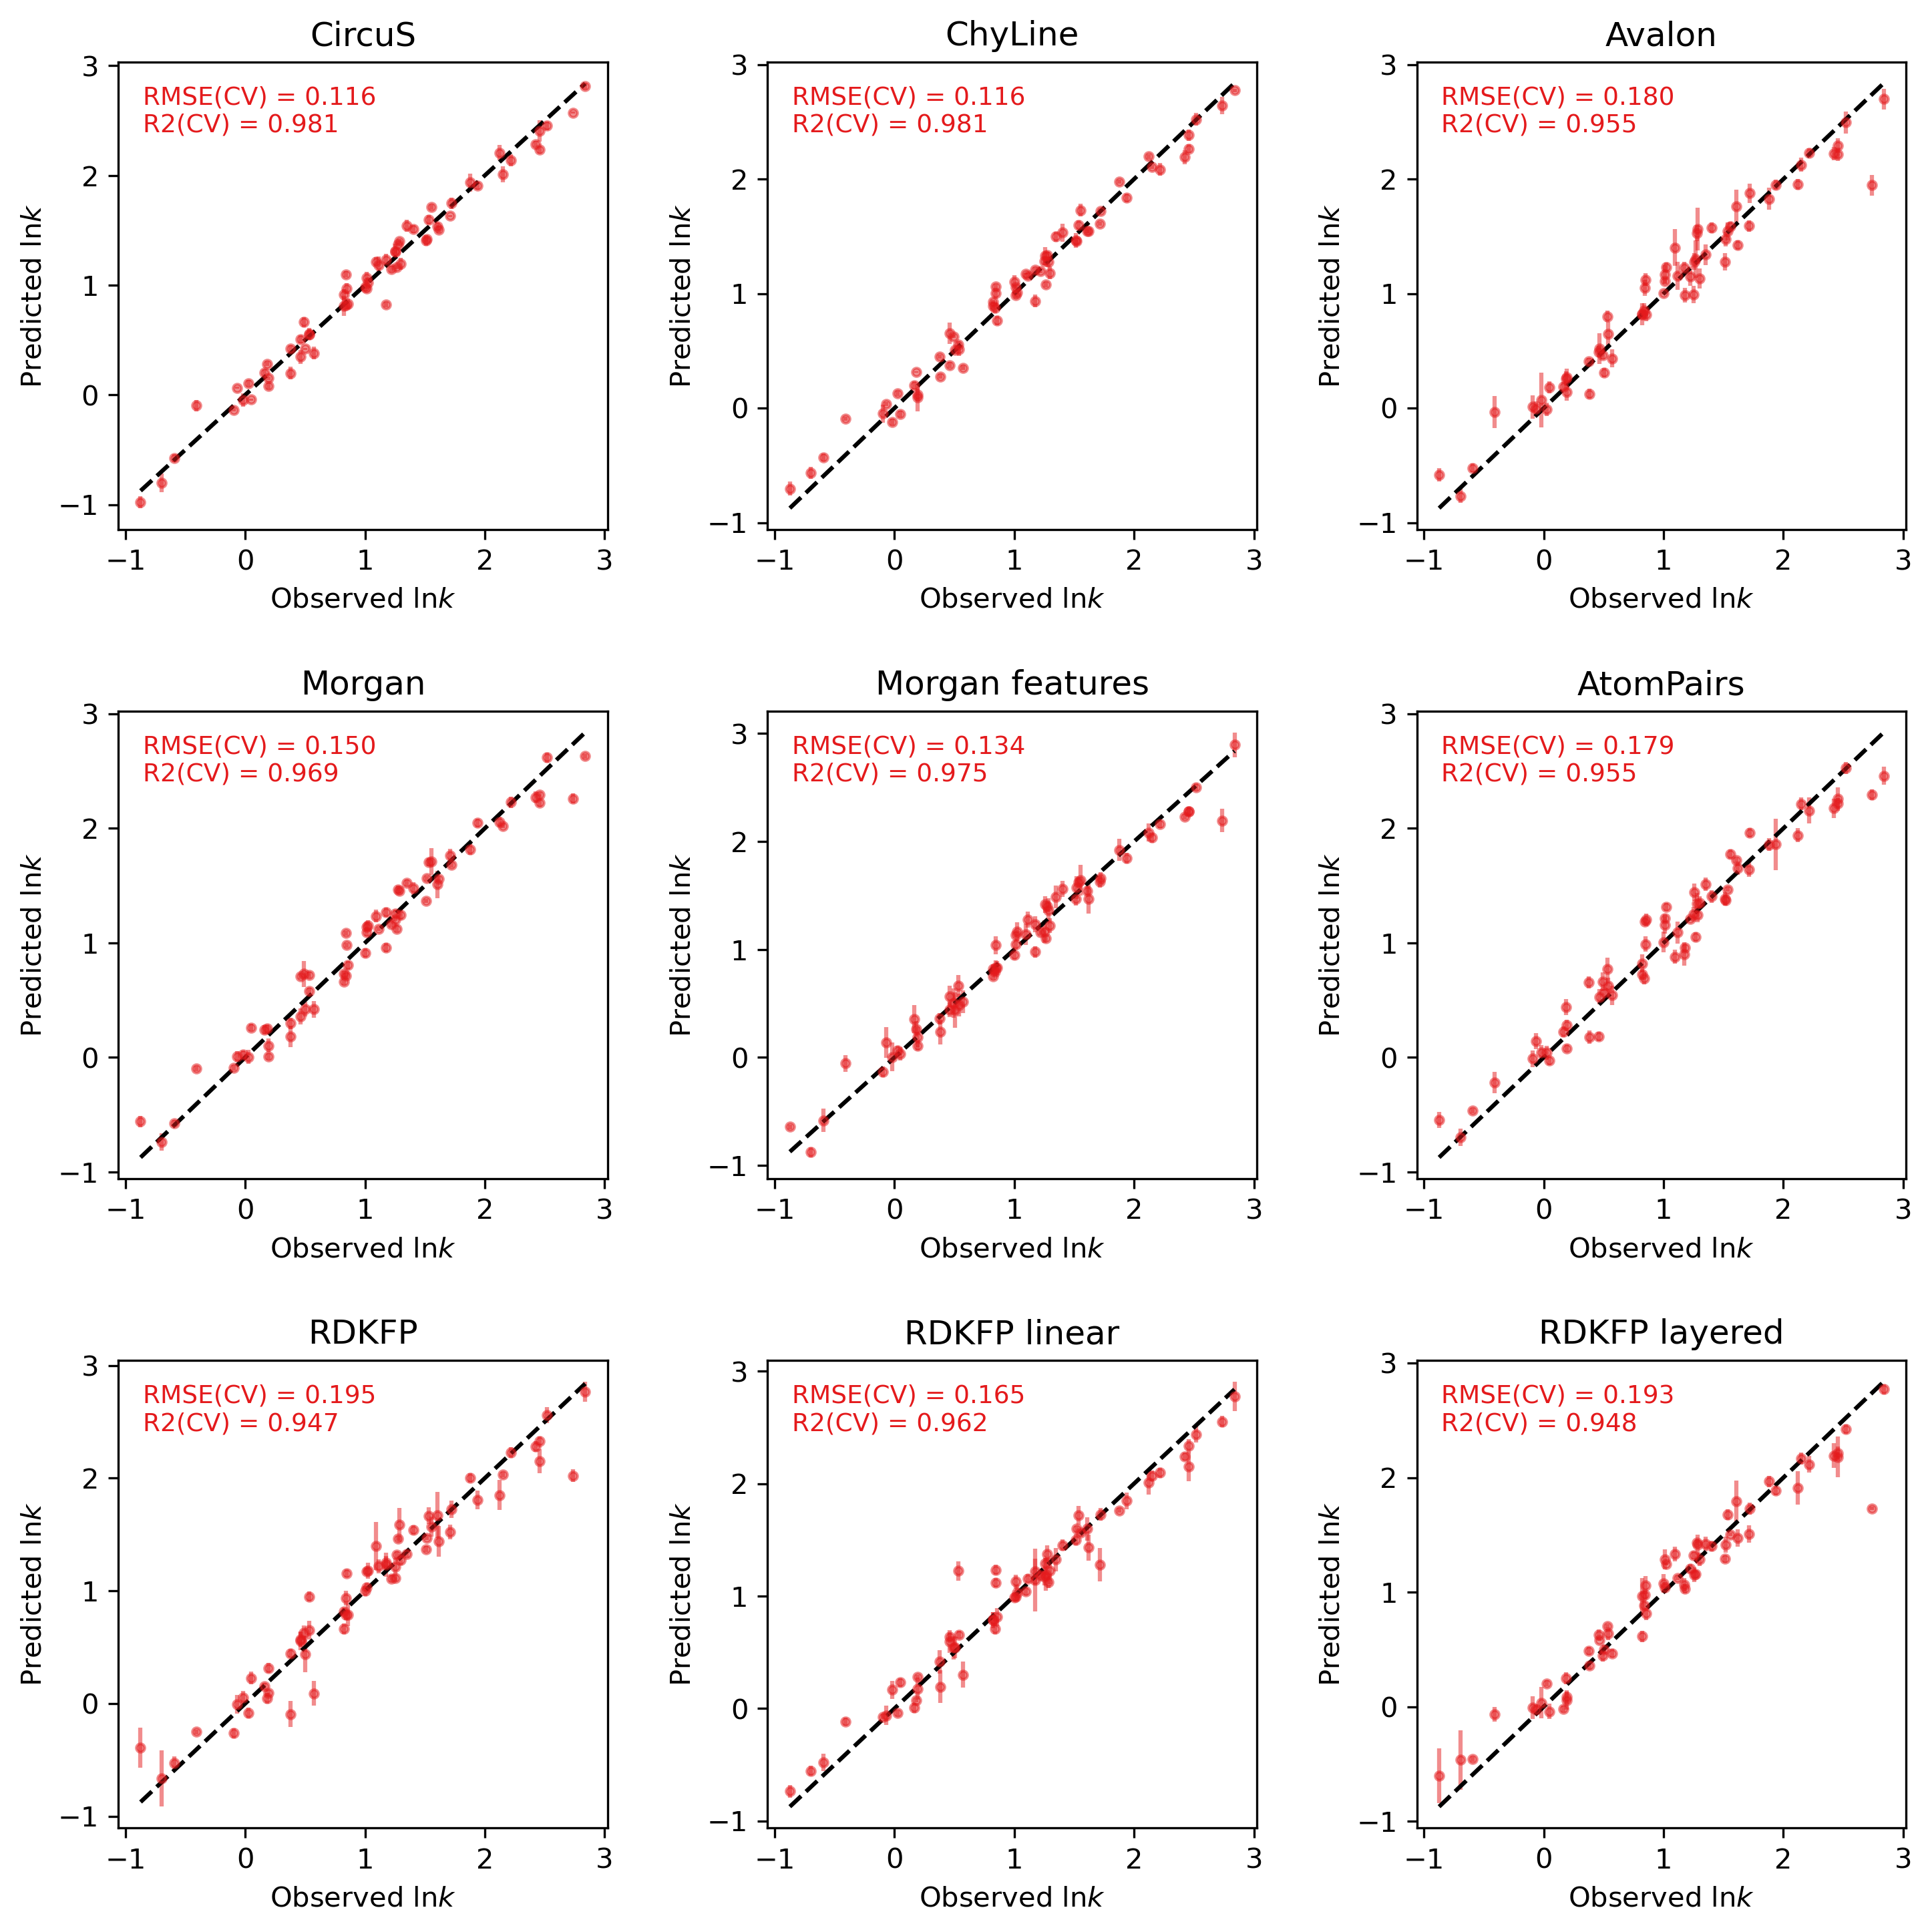

In [3]:
names = {'RDKFP':'CV_results/LnRF_rdkfp_SVR',
         'RDKFP layered':'CV_results/LnRF_layered_SVR',
         'ChyLine':'CV_results/LnRF_chyline_SVR',
         'Morgan':'CV_results/LnRF_morgan_SVR',
         'CircuS':'CV_results/LnRF_circus_SVR',
         'RDKFP linear':'CV_results/LnRF_rdkfplinear_SVR',
         'AtomPairs':'CV_results/LnRF_atompairs_SVR',
         'Morgan features':'CV_results/LnRF_morganfeatures_SVR',
         'Avalon':'CV_results/LnRF_avalon_SVR'}

fig, ax = plt.subplots(3, 3, figsize=(10,10), dpi=300, facecolor="white")

for i, dtype in enumerate(["CircuS", "ChyLine", "Avalon", "Morgan", 'Morgan features', 'AtomPairs', 
                           "RDKFP", "RDKFP linear", 'RDKFP layered']):
    d = dtype.lower()

    best = pd.read_table(names[dtype]+'/trials.best', sep=' ').iloc[0].trial
    cv_res = pd.read_table(names[dtype]+"/trial."+str(best)+"/predictions", sep=' ')
    a = cv_res["Exp_LnRF.observed"]
    b = cv_res[['Exp_LnRF.predicted.repeat'+str(i) for i in range(1,6)]]
    
    ax[i//3, i%3].errorbar(a,b.mean(axis=1),
                           b.std(axis=1), fmt=".", color=colors[0], alpha=0.5)
    
    ax[i//3, i%3].plot([a.min(), a.max()], [a.min(), a.max()], "k--")
    ax[i//3, i%3].set_xlabel(r"Observed ln$k$")
    ax[i//3, i%3].set_ylabel(r"Predicted ln$k$")
    ax[i//3, i%3].set_title(dtype)
    textstr = "\n".join([
        "RMSE(CV) = %.3f"  % (rmse(a,b.mean(axis=1)), ),
        "R2(CV) = %.3f"  % (r2(a,b.mean(axis=1)), )
            ])
    ax[i//3, i%3].text(0.05, 0.95, textstr, transform=ax[i//3, i%3].transAxes,
                       fontsize=9, color=colors[0],
                       verticalalignment="top", horizontalalignment="left",
                       bbox={"boxstyle":"round", "facecolor":"white", "alpha":0})
    

plt.tight_layout(pad=2)
#plt.savefig("All models lnRF.png", dpi=300)

# Retention time ($t_R$) cross-validation

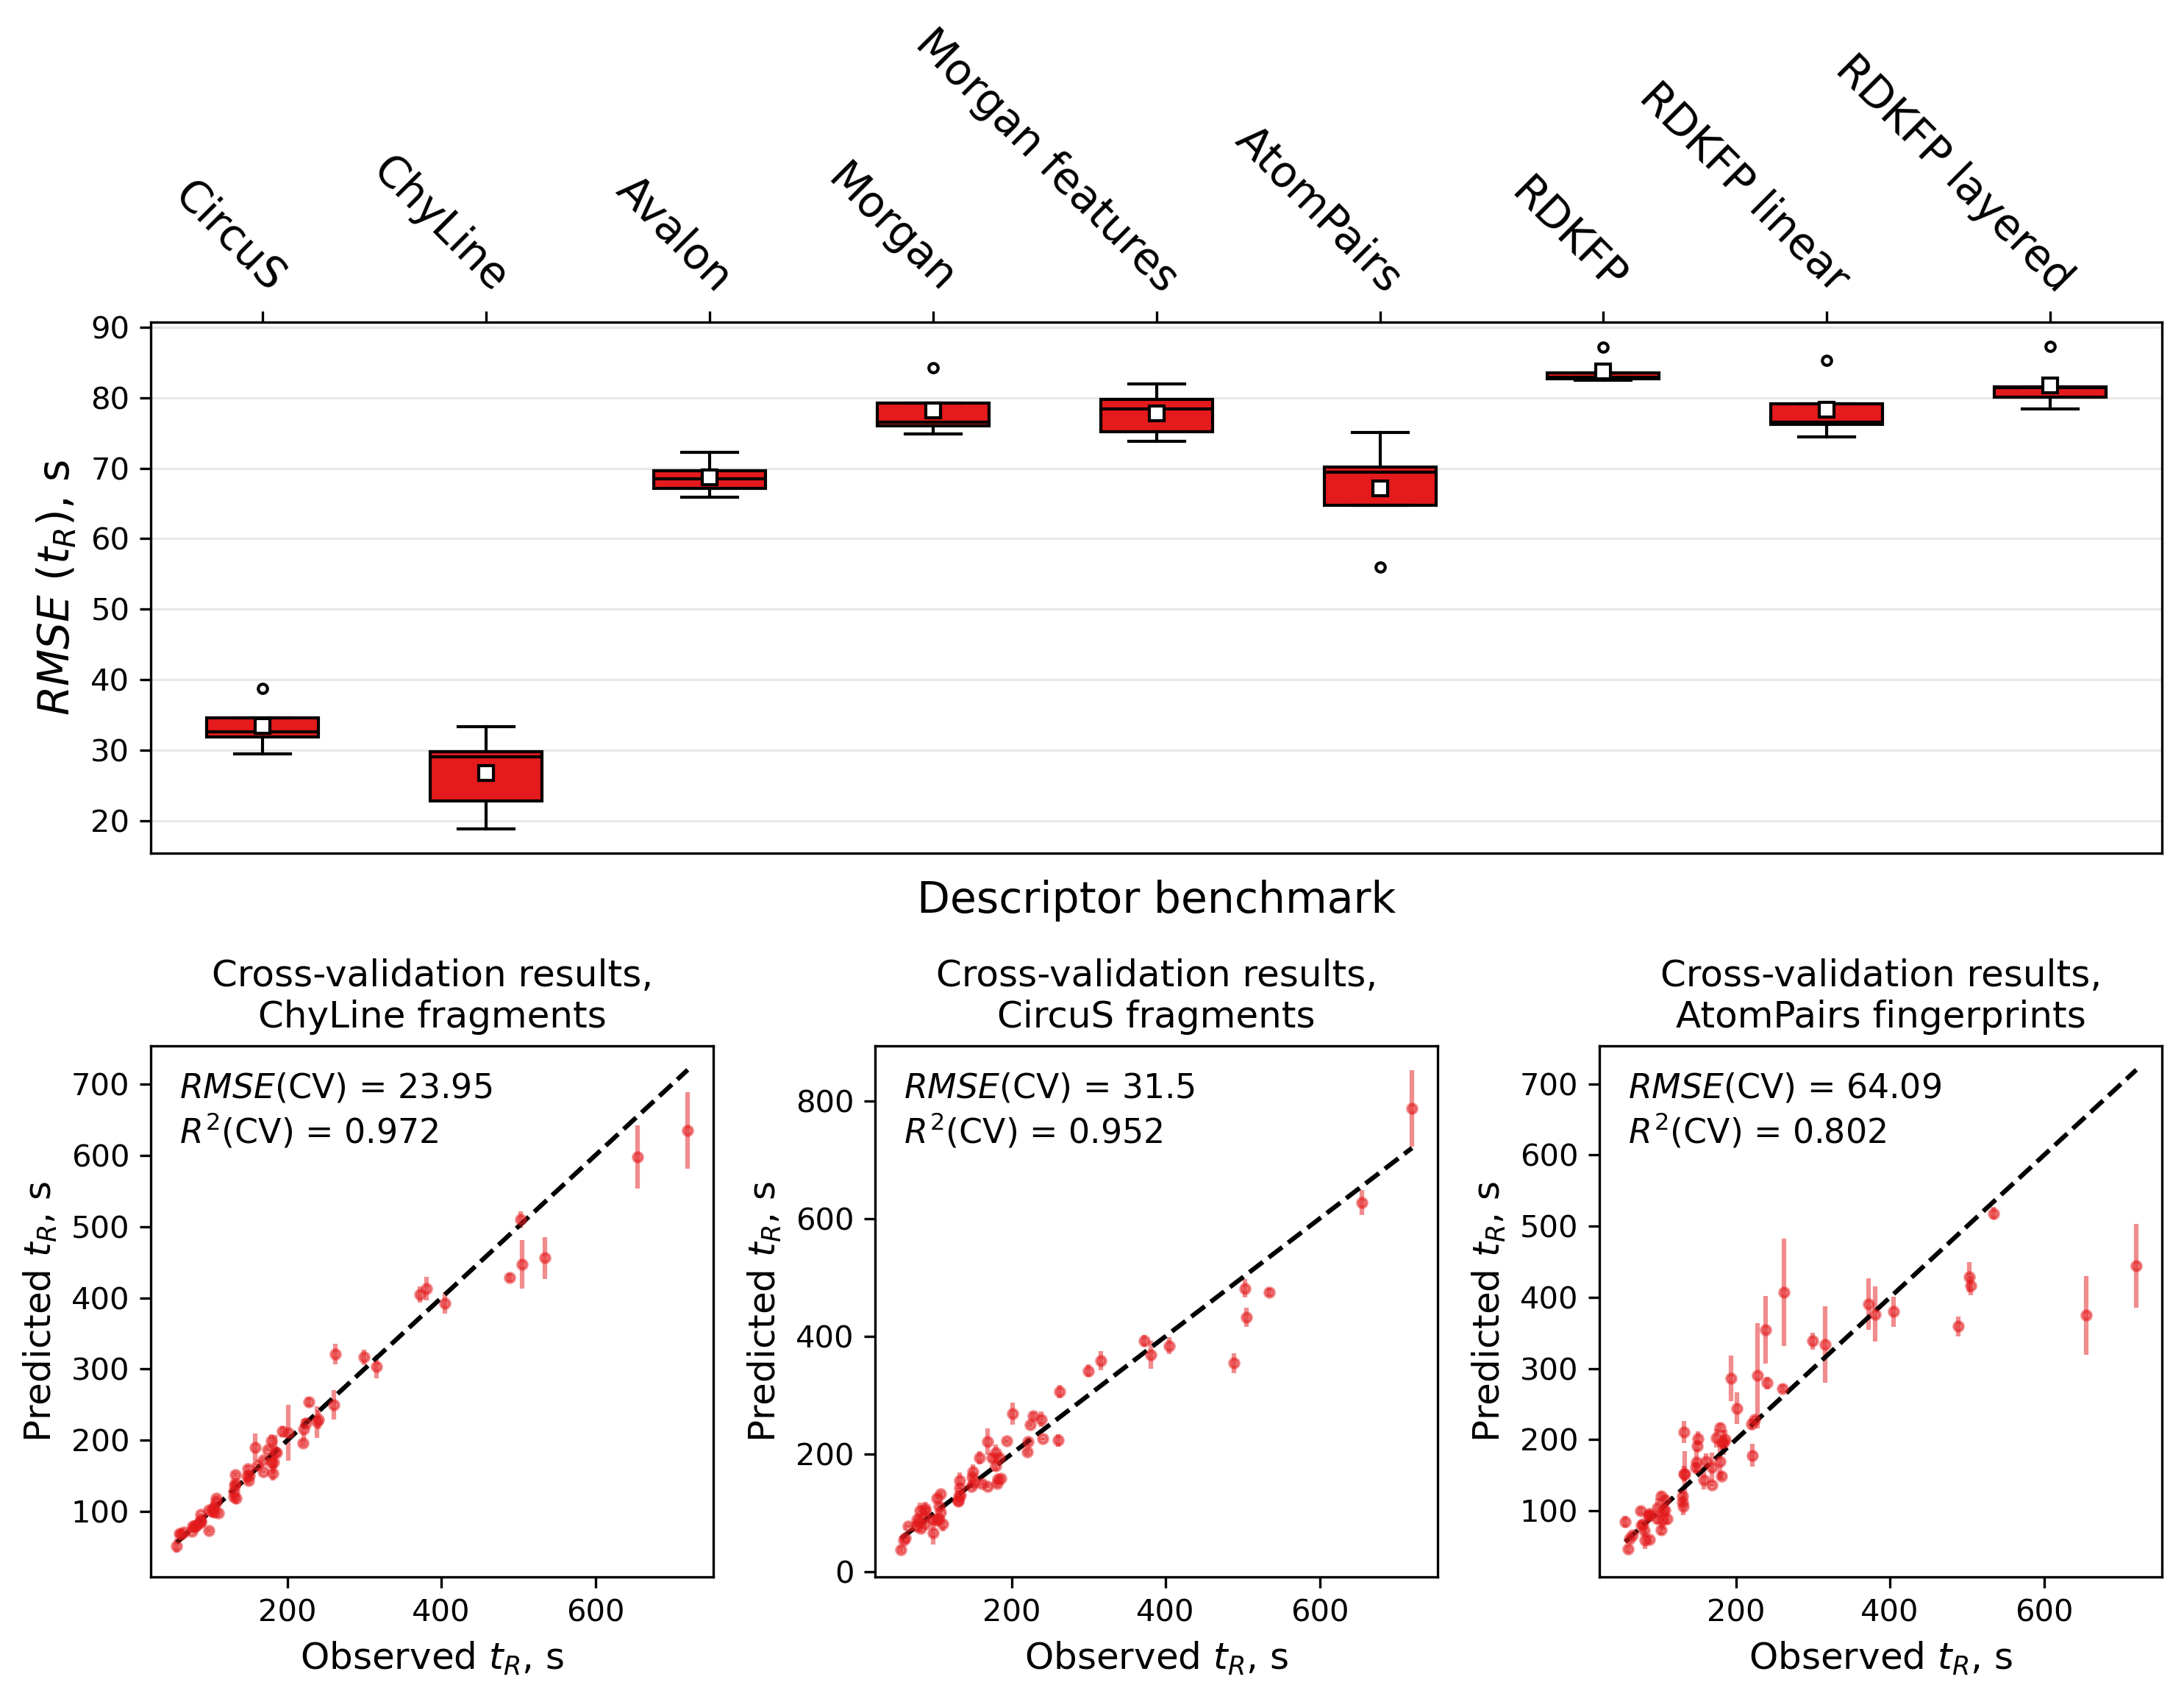

In [4]:
names = {'RDKFP':'CV_results/RT_rdkfp_SVR',
         'RDKFP layered':'CV_results/RT_layered_SVR',
         'ChyLine':'CV_results/RT_chyline_SVR',
         'Morgan':'CV_results/RT_morgan_SVR',
         'CircuS':'CV_results/RT_circus_SVR',
         'RDKFP linear':'CV_results/RT_rdkfplinear_SVR',
         'AtomPairs':'CV_results/RT_atompairs_SVR',
         'Morgan features':'CV_results/RT_morganfeatures_SVR',
         'Avalon':'CV_results/RT_avalon_SVR'}

fig = plt.figure(figsize = (10,7.8), dpi=300, facecolor="w")


ax1 = plt.subplot2grid((2, 3), (0, 0), colspan=3)
ax2 = plt.subplot2grid((2, 3), (1, 0))
ax3 = plt.subplot2grid((2, 3), (1, 1))
ax4 = plt.subplot2grid((2, 3), (1, 2))

cv_rmse_results = []
for i, dtype in enumerate(["CircuS", "ChyLine", "Avalon", "Morgan", 'Morgan features', 'AtomPairs', 
                           "RDKFP", "RDKFP linear", 'RDKFP layered']):
    d = dtype.lower()
    cv_rmse_results.append([])

    best = pd.read_table(names[dtype]+'/trials.best', sep=' ').iloc[0].trial
    cv_res = pd.read_table(names[dtype]+"/trial."+str(best)+"/predictions", sep=' ')
    a = cv_res["Exp_RT.observed"]
    for i in range(1,6):
        b = cv_res['Exp_RT.predicted.repeat'+str(i)]
        cv_rmse_results[-1].append(rmse(a,b))

bp1 = ax1.boxplot(cv_rmse_results, positions=[0,1,2,3,4,5,6,7,8],
                  patch_artist=True, showmeans=True)
for median in bp1['medians']:
    median.set(color='k', linewidth=1)
for mean in bp1['means']:
    mean.set(marker='s', markerfacecolor='w', markeredgecolor='k', markersize=5)
for item in ['boxes', 'whiskers', 'fliers', 'caps']:
        plt.setp(bp1[item], color='k')
plt.setp(bp1["boxes"], facecolor=colors[0], edgecolor='k')
plt.setp(bp1["fliers"], markeredgecolor='k', markersize=3)

ax1.set_xticks([0,1,2,3,4,5,6,7,8])
ax1.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
ax1.set_xticklabels(["CircuS", "ChyLine", "Avalon", "Morgan", 'Morgan features', 'AtomPairs', 
                           "RDKFP", "RDKFP linear", 'RDKFP layered'], 
                    rotation=-45, fontsize=14,
                    ha="right",rotation_mode="anchor")
ax1.set_ylabel(r"$RMSE$ ($t_R$), s", fontsize=14)#, rotation=0, labelpad=-15, loc="top")
#ax.set_ylim([0.75, 0.95])
ax1.grid(color="lightgrey", axis="y", alpha=.5)
ax1.text(0.5, -0.05, 'Descriptor benchmark', transform=ax1.transAxes,
                       fontsize=14, color='k',
                       verticalalignment="top", horizontalalignment="center")

best = pd.read_table(names['ChyLine']+'/trials.best', sep=' ').iloc[0].trial
cv_res = pd.read_table(names['ChyLine']+"/trial."+str(best)+"/predictions", sep=' ')
a = cv_res["Exp_RT.observed"]
b = cv_res[['Exp_RT.predicted.repeat'+str(i) for i in range(1,6)]]
    
ax2.errorbar(a,b.mean(axis=1), b.std(axis=1), fmt=".", color=colors[0], alpha=0.5, label="CV")
    
ax2.plot([a.min(), a.max()], [a.min(), a.max()], "k--")

ax2.set_xlabel(r"Observed $t_R$, s", fontsize=12)
ax2.set_ylabel(r"Predicted $t_R$, s", fontsize=12)
ax2.set_title('Cross-validation results,\nChyLine fragments', fontsize=12)
textstr = r"$RMSE$(CV) = " + str(round(rmse(a,b.mean(axis=1)),2)) + '\n' + r"$R^2$(CV) = " + str(round(r2(a,b.mean(axis=1)), 3))
ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes,
                       fontsize=11, color='k',
                       verticalalignment="top", horizontalalignment="left",
                       bbox={"boxstyle":"round", "facecolor":"white", "alpha":0})

best = pd.read_table(names['CircuS']+'/trials.best', sep=' ').iloc[0].trial
cv_res = pd.read_table(names['CircuS']+"/trial."+str(best)+"/predictions", sep=' ')
a = cv_res["Exp_RT.observed"]
b = cv_res[['Exp_RT.predicted.repeat'+str(i) for i in range(1,6)]]
    
ax3.errorbar(a,b.mean(axis=1), b.std(axis=1), fmt=".", color=colors[0], alpha=0.5, label="CV")
    
ax3.plot([a.min(), a.max()], [a.min(), a.max()], "k--")

ax3.set_xlabel(r"Observed $t_R$, s", fontsize=12)
ax3.set_ylabel(r"Predicted $t_R$, s", fontsize=12)
ax3.set_title('Cross-validation results,\nCircuS fragments', fontsize=12)
textstr = r"$RMSE$(CV) = " + str(round(rmse(a,b.mean(axis=1)),2)) + '\n' + r"$R^2$(CV) = " + str(round(r2(a,b.mean(axis=1)), 3))
ax3.text(0.05, 0.95, textstr, transform=ax3.transAxes,
                       fontsize=11, color='k',
                       verticalalignment="top", horizontalalignment="left",
                       bbox={"boxstyle":"round", "facecolor":"white", "alpha":0})

best = pd.read_table(names['AtomPairs']+'/trials.best', sep=' ').iloc[0].trial
cv_res = pd.read_table(names['AtomPairs']+"/trial."+str(best)+"/predictions", sep=' ')
a = cv_res["Exp_RT.observed"]
b = cv_res[['Exp_RT.predicted.repeat'+str(i) for i in range(1,6)]]
    
ax4.errorbar(a,b.mean(axis=1), b.std(axis=1), fmt=".", color=colors[0], alpha=0.5, label="CV")
    
ax4.plot([a.min(), a.max()], [a.min(), a.max()], "k--")

ax4.set_xlabel(r"Observed $t_R$, s", fontsize=12)
ax4.set_ylabel(r"Predicted $t_R$, s", fontsize=12)
ax4.set_title('Cross-validation results,\nAtomPairs fingerprints', fontsize=12)
textstr = r"$RMSE$(CV) = " + str(round(rmse(a,b.mean(axis=1)),2)) + '\n' + r"$R^2$(CV) = " + str(round(r2(a,b.mean(axis=1)), 3))
ax4.text(0.05, 0.95, textstr, transform=ax4.transAxes,
                       fontsize=11, color='k',
                       verticalalignment="top", horizontalalignment="left",
                       bbox={"boxstyle":"round", "facecolor":"white", "alpha":0})

plt.tight_layout()
#plt.savefig("Benchmark RT.png", dpi=300)

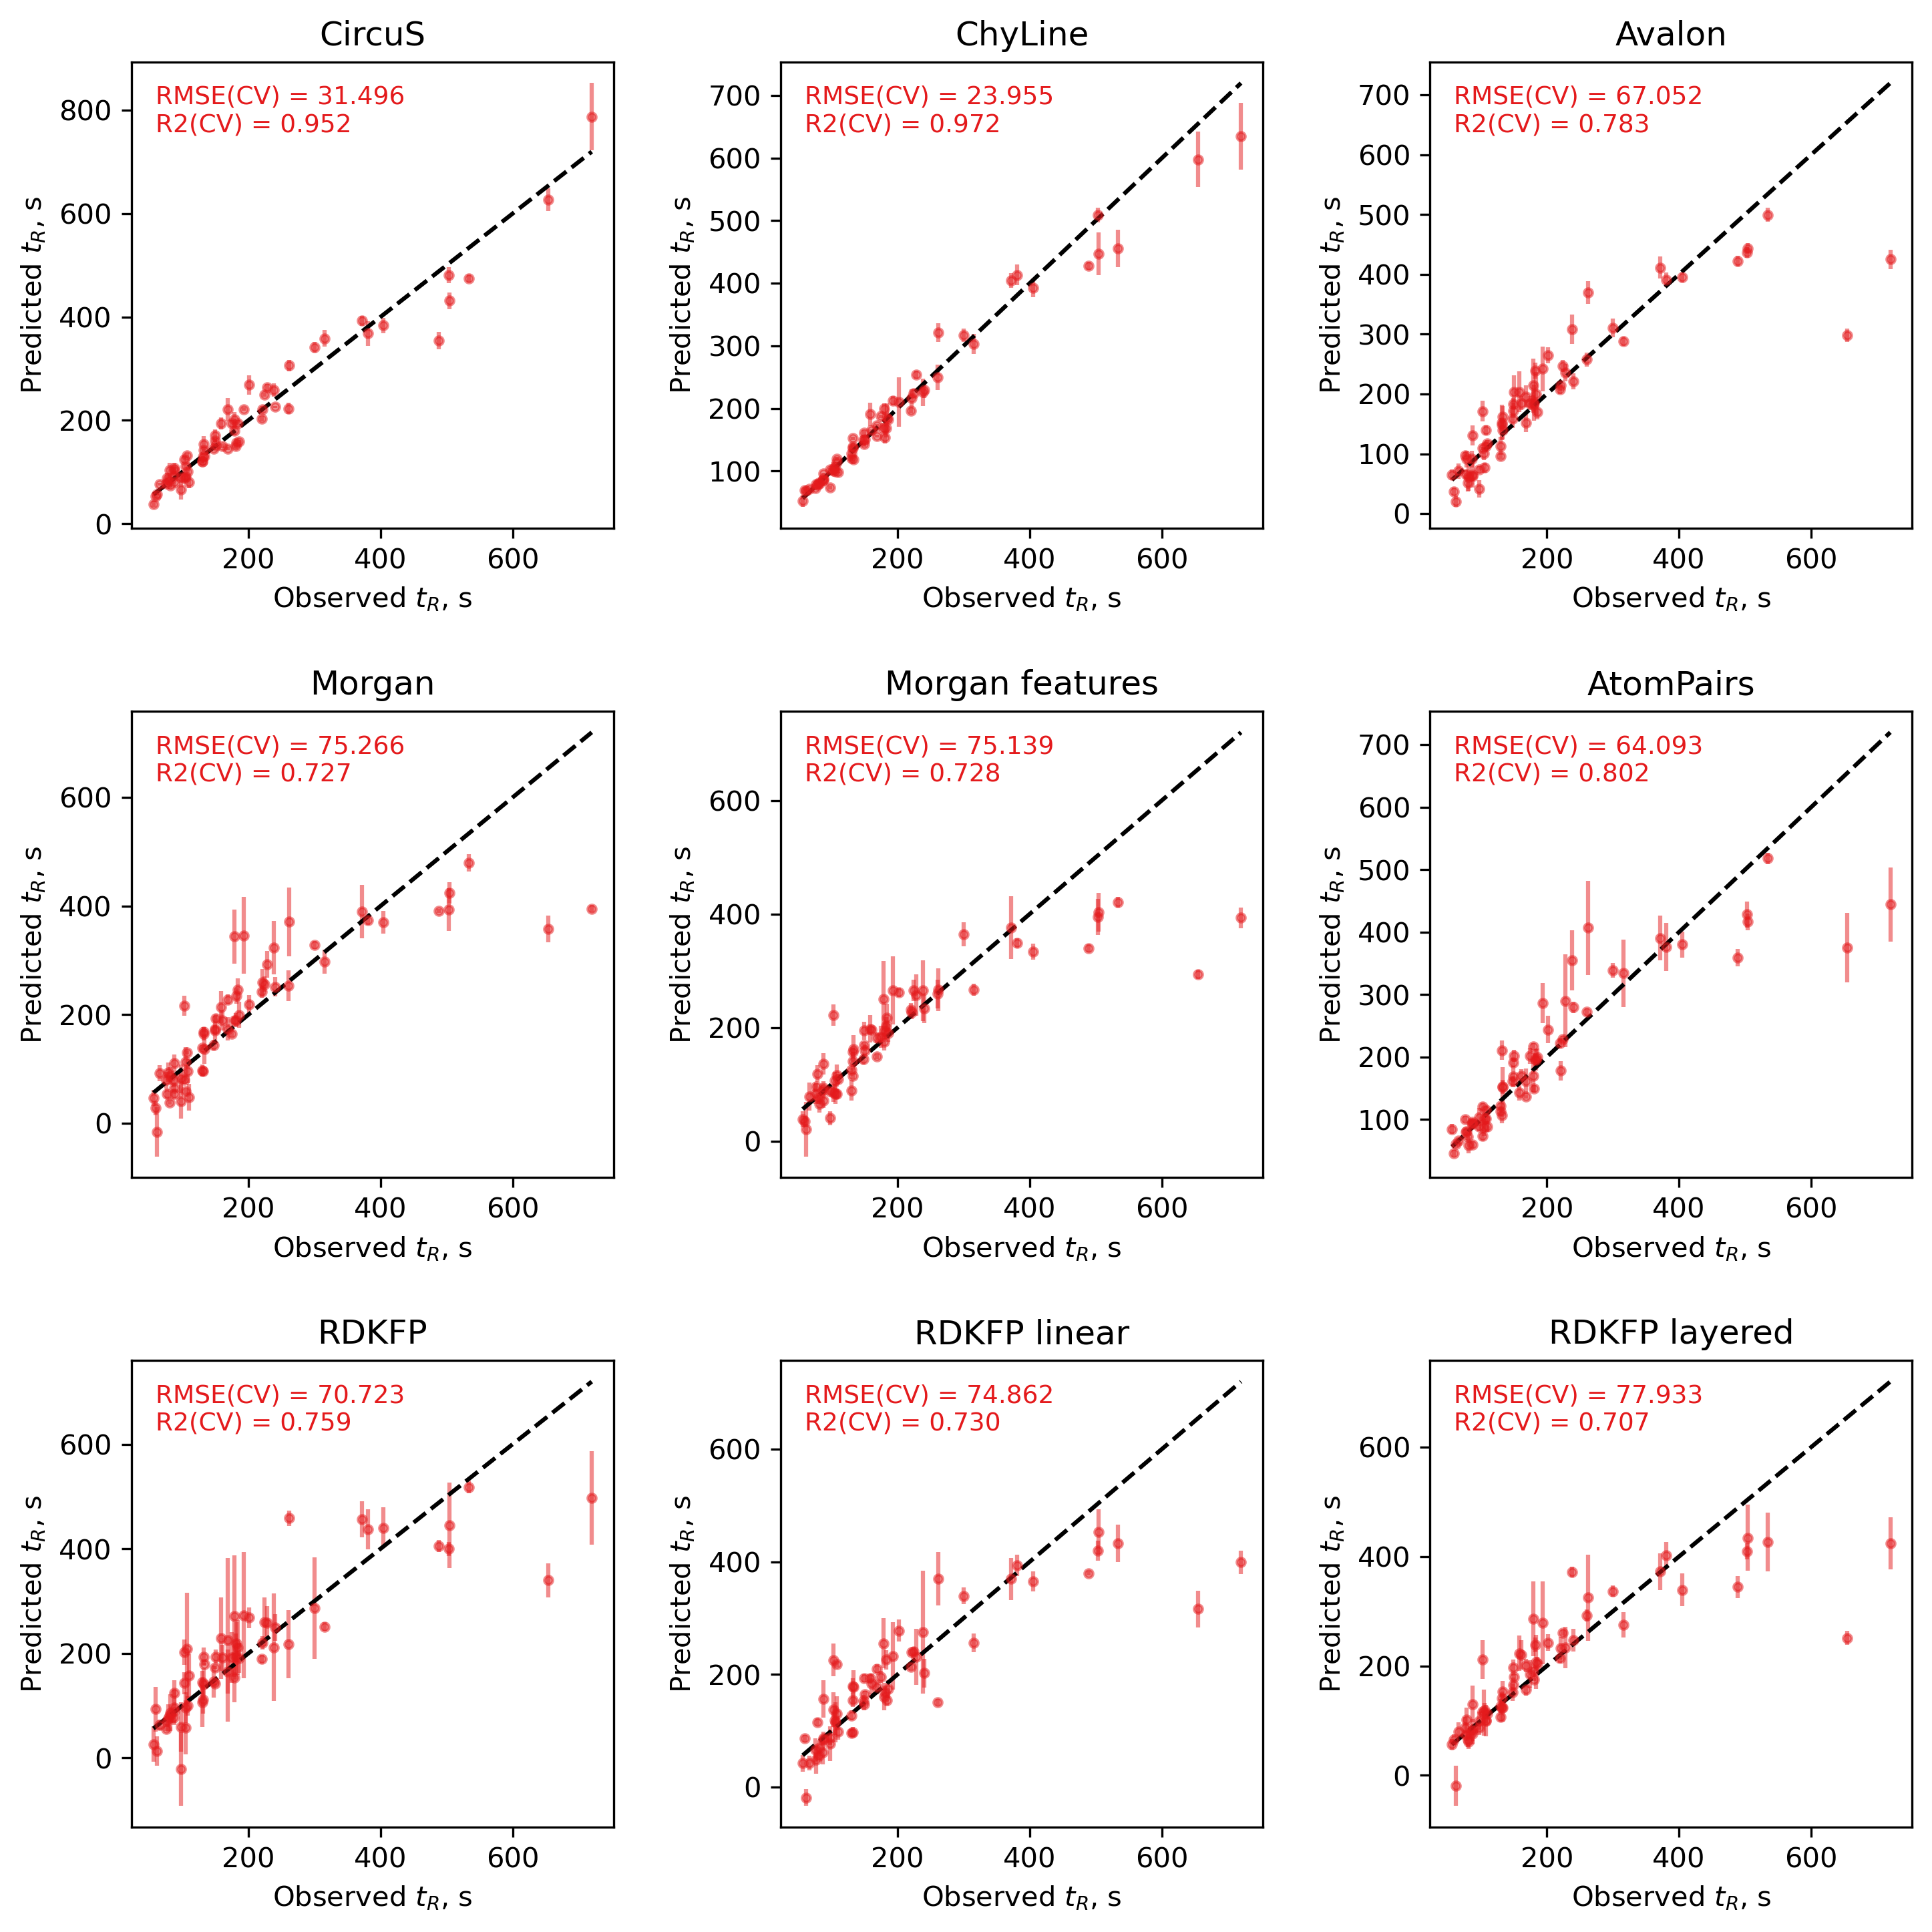

In [5]:
names = {'RDKFP':'CV_results/RT_rdkfp_SVR',
         'RDKFP layered':'CV_results/RT_layered_SVR',
         'ChyLine':'CV_results/RT_chyline_SVR',
         'Morgan':'CV_results/RT_morgan_SVR',
         'CircuS':'CV_results/RT_circus_SVR',
         'RDKFP linear':'CV_results/RT_rdkfplinear_SVR',
         'AtomPairs':'CV_results/RT_atompairs_SVR',
         'Morgan features':'CV_results/RT_morganfeatures_SVR',
         'Avalon':'CV_results/RT_avalon_SVR'}

fig, ax = plt.subplots(3, 3, figsize=(10,10), dpi=300, facecolor="white")

for i, dtype in enumerate(["CircuS", "ChyLine", "Avalon", "Morgan", 'Morgan features', 'AtomPairs', 
                           "RDKFP", "RDKFP linear", 'RDKFP layered']):
    d = dtype.lower()

    best = pd.read_table(names[dtype]+'/trials.best', sep=' ').iloc[0].trial
    cv_res = pd.read_table(names[dtype]+"/trial."+str(best)+"/predictions", sep=' ')
    a = cv_res["Exp_RT.observed"]
    b = cv_res[['Exp_RT.predicted.repeat'+str(i) for i in range(1,6)]]
    
    ax[i//3, i%3].errorbar(a,b.mean(axis=1),
                           b.std(axis=1), fmt=".", color=colors[0], alpha=0.5)
    
    ax[i//3, i%3].plot([a.min(), a.max()], [a.min(), a.max()], "k--")
    ax[i//3, i%3].set_xlabel(r"Observed $t_R$, s")
    ax[i//3, i%3].set_ylabel(r"Predicted $t_R$, s")
    ax[i//3, i%3].set_title(dtype)
    textstr = "\n".join([
        "RMSE(CV) = %.3f"  % (rmse(a,b.mean(axis=1)), ),
        "R2(CV) = %.3f"  % (r2(a,b.mean(axis=1)), )
            ])
    ax[i//3, i%3].text(0.05, 0.95, textstr, transform=ax[i//3, i%3].transAxes,
                       fontsize=9, color=colors[0],
                       verticalalignment="top", horizontalalignment="left",
                       bbox={"boxstyle":"round", "facecolor":"white", "alpha":0})
    

plt.tight_layout(pad=2)
#plt.savefig("All models RT.png", dpi=300)

## Data for training and testing models

In [6]:
training_data = pd.read_csv("Training_set_64.csv")
mols = [smiles(c) for c in training_data["SMILES"]]
[m.canonicalize() for m in mols]
training_data["mol"] = mols

test_set = pd.read_excel("External_test_set.xlsx")
test = [smiles(c) for c in test_set["SMILES"]]
[m.canonicalize() for m in test]
test_set["mol"] = test

# Prediction of ln$k$

In [7]:
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from doptools import get_raw_calculator

names = {'RDKFP':'CV_results/LnRF_rdkfp_SVR',
         'RDKFP layered':'CV_results/LnRF_layered_SVR',
         'ChyLine':'CV_results/LnRF_chyline_SVR',
         'Morgan':'CV_results/LnRF_morgan_SVR',
         'CircuS':'CV_results/LnRF_circus_SVR',
         'RDKFP linear':'CV_results/LnRF_rdkfplinear_SVR',
         'AtomPairs':'CV_results/LnRF_atompairs_SVR',
         'Morgan features':'CV_results/LnRF_morganfeatures_SVR',
         'Avalon':'CV_results/LnRF_avalon_SVR'}

pipelines = {}

for n in names:
    best = pd.read_table(names[n]+'/trials.best', sep=' ').iloc[0]
    if n == "ChyLine" or n == "CircuS":
        frg = get_raw_calculator(n.lower(), {"lower":int(best["desc"].split("_")[-2]), "upper":int(best["desc"].split("_")[-1])})
    elif n == "AtomPairs" or n == "Avalon" or n == "Torsion":
        frg = get_raw_calculator(n.lower(), {"nBits":int(best["desc"].split("_")[-1])})
    elif n == "Morgan features":
        frg = get_raw_calculator("morganfeatures", {"nBits":int(best["desc"].split("_")[-2]), "radius":int(best["desc"].split("_")[-1])})
    elif n == "RDKFP linear":
        frg = get_raw_calculator("rdkfplinear", {"nBits":int(best["desc"].split("_")[-2]), "radius":int(best["desc"].split("_")[-1])})
    elif n == "RDKFP layered":
        frg = get_raw_calculator("layered", {"nBits":int(best["desc"].split("_")[-2]), "radius":int(best["desc"].split("_")[-1])})
    else:
        frg = get_raw_calculator(n.lower(), {"nBits":int(best["desc"].split("_")[-2]), "radius":int(best["desc"].split("_")[-1])})
        
    vrt = VarianceThreshold(0)
    model = SVR(C=best["C"], kernel=best["kernel"], coef0=best["coef0"])
    pipeline = Pipeline([("fragments", frg), ("variance", vrt), ("model", model)])

    pipeline.fit(training_data["mol"], training_data["Exp_LnRF"])
    pipelines[n] = pipeline

    preds = pipeline.predict(test_set["mol"])
    test_set["Predicted ("+n+")"] = preds

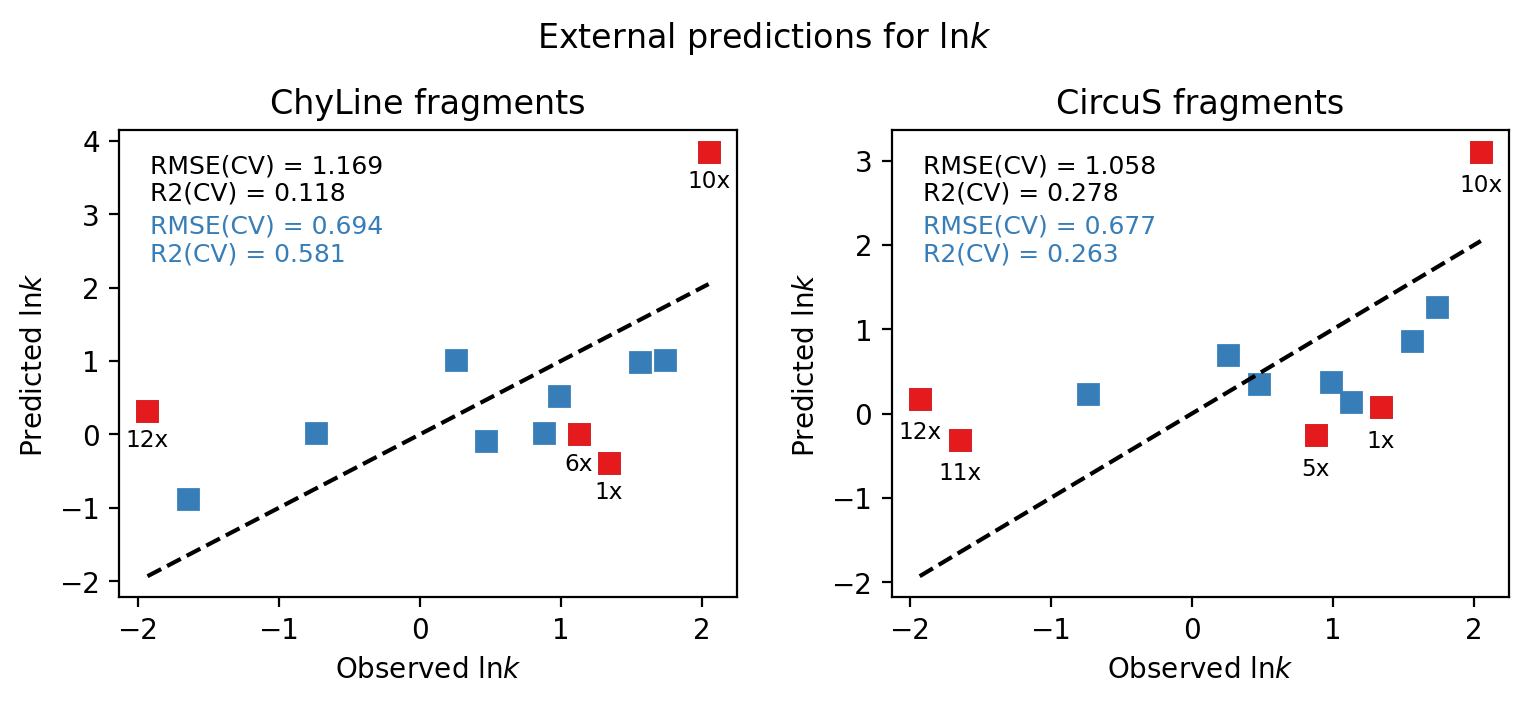

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), dpi=200, facecolor="w")

x = test_set["LnRF"]
y = test_set["Predicted (ChyLine)"]

rmse1 = root_mean_squared_error(x, y)
mae1 = mean_absolute_error(x, y)
r2_1 = r2_score(x, y)

not_outlier_indices = np.where(np.abs(x-y)<1)[0]
rmse_no = rmse(x.iloc[not_outlier_indices], y.iloc[not_outlier_indices])
mae_no = mean_absolute_error(x.iloc[not_outlier_indices], y.iloc[not_outlier_indices])
r2_no = r2(x.iloc[not_outlier_indices], y.iloc[not_outlier_indices])

axes[0].plot(x, y, color=colors[1], markersize=7, marker="s", linestyle="")

outlier_indices = np.where(np.abs(x-y)>1)[0]
axes[0].plot(x.iloc[outlier_indices], y.iloc[outlier_indices], color=colors[0], markersize=7, marker="s", linestyle="")
for i in outlier_indices:
    axes[0].text(x.iloc[i], y.iloc[i]-0.4, str(i+1)+"x", size="small", va="center", ha="center")
axes[0].plot([x.min(), x.max()],[x.min(), x.max()], "--", color="k")
metrics_text = textstr = "\n".join([
        "RMSE(CV) = %.3f"  % (rmse1, ),
        "R2(CV) = %.3f"  % (r2_1, )
            ])
axes[0].text(0.05, 0.95, metrics_text, transform=axes[0].transAxes, 
          fontsize=9, color="k", verticalalignment="top", horizontalalignment="left",
          bbox={"boxstyle":"round", "facecolor":"white", "alpha":0})

metrics_text2 = textstr = "\n".join([
        "RMSE(CV) = %.3f"  % (rmse_no, ),
        "R2(CV) = %.3f"  % (r2_no, )
            ])
axes[0].text(0.05, 0.82, metrics_text2, transform=axes[0].transAxes, 
          fontsize=9, color=colors[1], verticalalignment="top", horizontalalignment="left",
          bbox={"boxstyle":"round", "facecolor":"white", "alpha":0})
axes[0].set_title("ChyLine fragments")
axes[0].set_xlabel("Observed ln$k$")
axes[0].set_ylabel("Predicted ln$k$")

x = test_set["LnRF"]
y = test_set["Predicted (CircuS)"]

rmse1 = root_mean_squared_error(x, y)
mae1 = mean_absolute_error(x, y)
r2_1 = r2_score(x, y)

not_outlier_indices = np.where(np.abs(x-y)<1)[0]
rmse_no = rmse(x.iloc[not_outlier_indices], y.iloc[not_outlier_indices])
mae_no = mean_absolute_error(x.iloc[not_outlier_indices], y.iloc[not_outlier_indices])
r2_no = r2(x.iloc[not_outlier_indices], y.iloc[not_outlier_indices])

axes[1].plot(x, y, color=colors[1], markersize=7, marker="s", linestyle="")

outlier_indices = np.where(np.abs(x-y)>1)[0]
axes[1].plot(x.iloc[outlier_indices], y.iloc[outlier_indices], color=colors[0], markersize=7, marker="s", linestyle="")
axes[1].plot([x.min(), x.max()],[x.min(), x.max()], "--", color="k")
metrics_text = textstr = "\n".join([
        "RMSE(CV) = %.3f"  % (rmse1, ),
        "R2(CV) = %.3f"  % (r2_1, )
            ])
axes[1].text(0.05, 0.95, metrics_text, transform=axes[1].transAxes, 
          fontsize=9, color="k", verticalalignment="top", horizontalalignment="left",
          bbox={"boxstyle":"round", "facecolor":"white", "alpha":0})
for i in outlier_indices:
    axes[1].text(x.iloc[i], y.iloc[i]-0.4, str(i+1)+"x", size="small", va="center", ha="center")

metrics_text2 = textstr = "\n".join([
        "RMSE(CV) = %.3f"  % (rmse_no, ),
        "R2(CV) = %.3f"  % (r2_no, )
            ])
axes[1].text(0.05, 0.82, metrics_text2, transform=axes[1].transAxes, 
          fontsize=9, color=colors[1], verticalalignment="top", horizontalalignment="left",
          bbox={"boxstyle":"round", "facecolor":"white", "alpha":0})
axes[1].set_title("CircuS fragments")
axes[1].set_xlabel("Observed ln$k$")
axes[1].set_ylabel("Predicted ln$k$")

plt.suptitle(r"External predictions for ln$k$", y=0.90)
plt.tight_layout(pad=2)

#plt.savefig("External - lnRF.png", dpi=300)

# Prediction of $t_R$

In [9]:
names = {'RDKFP':'CV_results/RT_rdkfp_SVR',
         'RDKFP layered':'CV_results/RT_layered_SVR',
         'ChyLine':'CV_results/RT_chyline_SVR',
         'Morgan':'CV_results/RT_morgan_SVR',
         'CircuS':'CV_results/RT_circus_SVR',
         'RDKFP linear':'CV_results/RT_rdkfplinear_SVR',
         'AtomPairs':'CV_results/RT_atompairs_SVR',
         'Morgan features':'CV_results/RT_morganfeatures_SVR',
         'Avalon':'CV_results/RT_avalon_SVR'}

pipelines_RT = {}

for n in names:
    best = pd.read_table(names[n]+'/trials.best', sep=' ').iloc[0]
    if n == "ChyLine" or n == "CircuS":
        frg = get_raw_calculator(n.lower(), {"lower":int(best["desc"].split("_")[-2]), "upper":int(best["desc"].split("_")[-1])})
    elif n == "AtomPairs" or n == "Avalon" or n == "Torsion":
        frg = get_raw_calculator(n.lower(), {"nBits":int(best["desc"].split("_")[-1])})
    elif n == "Morgan features":
        frg = get_raw_calculator("morganfeatures", {"nBits":int(best["desc"].split("_")[-2]), "radius":int(best["desc"].split("_")[-1])})
    elif n == "RDKFP linear":
        frg = get_raw_calculator("rdkfplinear", {"nBits":int(best["desc"].split("_")[-2]), "radius":int(best["desc"].split("_")[-1])})
    elif n == "RDKFP layered":
        frg = get_raw_calculator("layered", {"nBits":int(best["desc"].split("_")[-2]), "radius":int(best["desc"].split("_")[-1])})
    else:
        frg = get_raw_calculator(n.lower(), {"nBits":int(best["desc"].split("_")[-2]), "radius":int(best["desc"].split("_")[-1])})
        
    vrt = VarianceThreshold(0)
    model = SVR(C=best["C"], kernel=best["kernel"], coef0=best["coef0"])
    pipeline = Pipeline([("fragments", frg), ("variance", vrt), ("model", model)])

    pipeline.fit(training_data["mol"], training_data["Exp_RT"])
    pipelines_RT[n] = pipeline

    preds = pipeline.predict(test_set["mol"])
    test_set["Predicted RT ("+n+")"] = preds

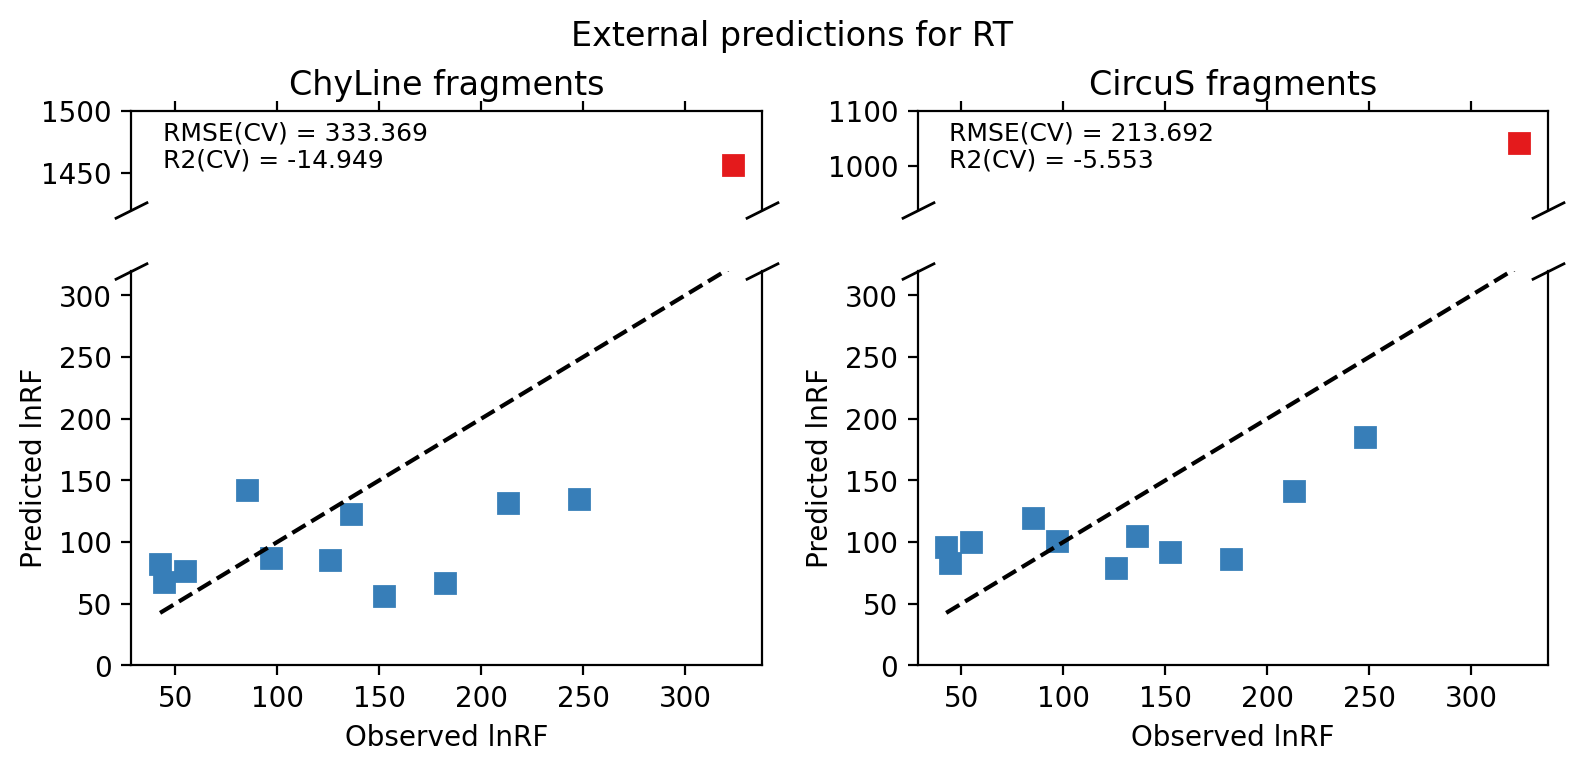

In [10]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(8, 4), dpi=200, facecolor="w")

gs = GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[1, 4])

#fig, axes = plt.subplots(2, 2, sharex=True, figsize=(8, 4), dpi=200, facecolor="w")
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])
ax4 = fig.add_subplot(gs[3])

x = test_set["RT"]
y = test_set["Predicted RT (ChyLine)"]

rmse1 = root_mean_squared_error(x, y)
mae1 = mean_absolute_error(x, y)
r2_1 = r2_score(x, y)

ax1.plot(x, y, color=colors[0], markersize=7, marker="s", linestyle="")
ax3.plot(x, y, color=colors[1], markersize=7, marker="s", linestyle="")

ax1.set_ylim(1420, 1500)  # outliers only
ax3.set_ylim(0, 320)  # most of the data

ax1.spines.bottom.set_visible(False)
ax3.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax3.xaxis.tick_bottom()


d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax3.plot([0, 1], [1, 1], transform=ax3.transAxes, **kwargs)

ax3.plot([x.min(), x.max()],[x.min(), x.max()], "--", color="k")
metrics_text = textstr = "\n".join([
        "RMSE(CV) = %.3f"  % (rmse1, ),
        "R2(CV) = %.3f"  % (r2_1, )
            ])
ax1.text(0.05, 0.9, metrics_text, transform=ax1.transAxes, 
          fontsize=9, color="k", verticalalignment="top", horizontalalignment="left",
          bbox={"boxstyle":"round", "facecolor":"white", "alpha":0})

ax1.set_title("ChyLine fragments")
ax3.set_xlabel("Observed lnRF")
ax3.set_ylabel("Predicted lnRF")

x = test_set["RT"]
y = test_set["Predicted RT (CircuS)"]

rmse1 = root_mean_squared_error(x, y)
mae1 = mean_absolute_error(x, y)
r2_1 = r2_score(x, y)

ax2.plot(x, y, color=colors[0], markersize=7, marker="s", linestyle="")
ax4.plot(x, y, color=colors[1], markersize=7, marker="s", linestyle="")

ax2.set_ylim(920, 1100)  # outliers only
ax4.set_ylim(0, 320)  # most of the data

ax2.spines.bottom.set_visible(False)
ax4.spines.top.set_visible(False)
ax2.xaxis.tick_top()
ax2.tick_params(labeltop=False)  # don't put tick labels at the top
ax4.xaxis.tick_bottom()

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax2.plot([0, 1], [0, 0], transform=ax2.transAxes, **kwargs)
ax4.plot([0, 1], [1, 1], transform=ax4.transAxes, **kwargs)

ax4.plot([x.min(), x.max()],[x.min(), x.max()], "--", color="k")
metrics_text = textstr = "\n".join([
        "RMSE(CV) = %.3f"  % (rmse1, ),
        "R2(CV) = %.3f"  % (r2_1, )
            ])
ax2.text(0.05, 0.9, metrics_text, transform=ax2.transAxes, 
          fontsize=9, color="k", verticalalignment="top", horizontalalignment="left",
          bbox={"boxstyle":"round", "facecolor":"white", "alpha":0})

ax2.set_title("CircuS fragments")
ax4.set_xlabel("Observed lnRF")
ax4.set_ylabel("Predicted lnRF")

plt.suptitle("External predictions for RT", y=0.95)
plt.tight_layout(pad=1)

#plt.savefig("External RT.png", dpi=300)

# Interpretation by ColorAtom

In [11]:
from pandas import Series
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from doptools import ColorAtom
from IPython.display import HTML, display

RWB = LinearSegmentedColormap.from_list("RWB", ["#0571b0","#92c5de","#f7f7f7","#f4a582","#ca0020"])

ca = ColorAtom(colormap=RWB)

ca.set_pipeline(pipelines["ChyLine"])

contr = []
for i in [0,5,9,11]:
    m = test_set["mol"].loc[i]
    contr += [v for v in ca.calculate_atom_contributions(m)[m].values()]

max_value = np.max(np.abs(contr))
for i in [0,5,9,11]: # visualizing only the outliers
    svgs = ca._draw_one_molecule(test_set["mol"].loc[i], colorbar=True, external_limits=[-max_value, max_value])
    no_wrap_div = '<div style="white-space: nowrap; align-items: middle">'+'{}'*len(svgs)+'</div>'
    display(HTML(no_wrap_div.format(*svgs)))